# Домашнее задание NLP 3
Что в векторе твоем?

**Цель:**
В этом ДЗ вы освоите работу с предобученными векторными представлениями.

<hr>

1. В качестве данных возьмите либо датасет, собранный в первом занятии (предпочтительно).Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.

2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена. Обучите random forest или градиентный бустинг (LightGBM или catboost) на полученных векторах и подберите оптимальную комбинацию гиперпараметров с помощью GridSearch

3. Теперь воспользуйтесь предобученными word2vec/fasttext эмбеддингами для векторизации текста. Векторизуйте тексты с помощью метода word2vec/fasttext c весами tf-idf. Повторите эксперимент из пункта 4 с использованием полученных в пункте 5 векторов

<hr>

**Критерии оценки:**
<li> Разбиение на train/test - 1 балл
<li> Предобработка текста при помощи tf-idf - 2 балла
<li> Обучение модели на tf-idf векторах - 2 балла
<li> Преобработка текста при помощи преобученных эмбеддингов word2vec/fasttext - 3 балла
<li> Обучение модели на предобученных эмбеддингах - 2 балл

# Часть 1. Обработка датасета

Для выполнения задания я буду использовать датасет из 20000 наблюдений, собранный в рамках 1-го задания с отзывами о реторанах Москвы https://www.restoran.ru/msk/opinions/.

Отзыв выглядит следующим образом:

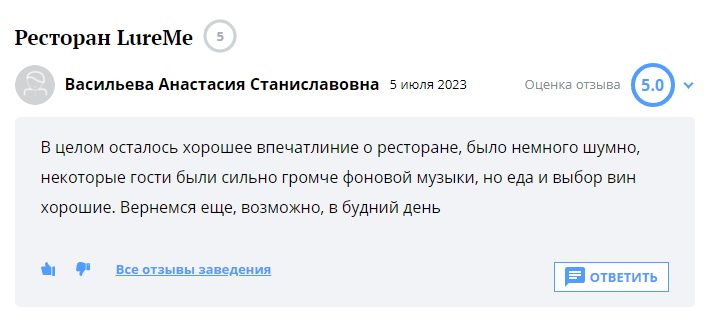


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('rest_reviews.csv', index_col= 0)
df.head(5)

,user,date,rating,place,summary_short,summary_full
0,Sasha,14 июня 2023,5.0,Караоке-бар DUETS,"Мы с девушкой праздновали годовщину в Duets, в...","Мы с девушкой праздновали годовщину в Duets, в..."
1,Дмитрий,13 июня 2023,5.0,Ресторан Tutta La Vita / Тутта Ла Вита,"Уютный ресторанчик, можно прийти на завтрак да...",NaN
2,Артём,13 июня 2023,5.0,Бар Virgins / Верджинс,"Не ходок в ночные заведенения, но был на дне р...","Не ходок в ночные заведенения, но был на дне р..."
3,mironova777w,11 июня 2023,5.0,Кафе Биджо,По всем критериям высшая оценка. Заехали с под...,По всем критериям высшая оценка. Заехали с под...
4,Евгения,11 июня 2023,5.0,Ресторан Генацвале на Арбате,"Очень понравилось. Атмосфера волшебная, улочки...","Очень понравилось. Атмосфера волшебная, улочки..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user           19970 non-null  object
 1   date           20000 non-null  object
 2   rating         19620 non-null  object
 3   place          16737 non-null  object
 4   summary_short  19964 non-null  object
 5   summary_full   11812 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


Посмотрим на пустые строки, в первую очередь интересует наличие рейтинга и текста отзыва. 

Соберем все отзывы в отдельную колонку: если есть полный отзыв, то будем использовать его, если нет - то короткую версию. Удалим те строки, где нет ни одной из версий отзыва.

In [4]:
df.isnull().sum()

user               30
date                0
rating            380
place            3263
summary_short      36
summary_full     8188
dtype: int64

In [5]:
df = df[(df['rating'].isnull() == False) & (df['rating'] != 'ыва')]
df['summary_fin'] = df[['summary_short', 'summary_full']].apply\
     (lambda df: df['summary_short'] if df['summary_full'] != '' else df['summary_full'], axis = 1)

import datetime
months = ["января", "февраля", "марта", "апреля", "мая", "июня", "июля", "августа", "сентября", "октября", "ноября",
              "декабря"]
def date_format(date):
    year = int(date.split(' ')[2])
    month = int(months.index(date.split(' ')[1]) + 1)
    day = int(date.split(' ')[0])
    return datetime.date(year, month, day)
df['date'] = df['date'].apply(date_format)

df = df[df['summary_fin'].isnull() == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19570 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user           19540 non-null  object
 1   date           19570 non-null  object
 2   rating         19570 non-null  object
 3   place          16311 non-null  object
 4   summary_short  19570 non-null  object
 5   summary_full   11605 non-null  object
 6   summary_fin    19570 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB


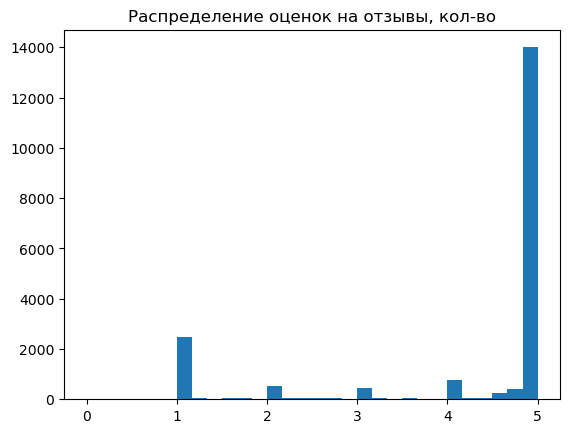

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

df['rating'] = df['rating'].astype('float')
plt.title('Распределение оценок на отзывы, кол-во')
plt.hist(df['rating'], bins=30)
plt.show()

Очевидна несбаланисровать классов - преобладание отличных отзывов. Не имеет смысла оставлять все пять рейтингов для анализа: введем 0 - негативный отзыв (все рейтинги меньше 4) и 1 - положительный отзыв (все рейтинги от 4 и выше).

In [7]:
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
df['rating'].value_counts()

1    15549
0     4021
Name: rating, dtype: int64

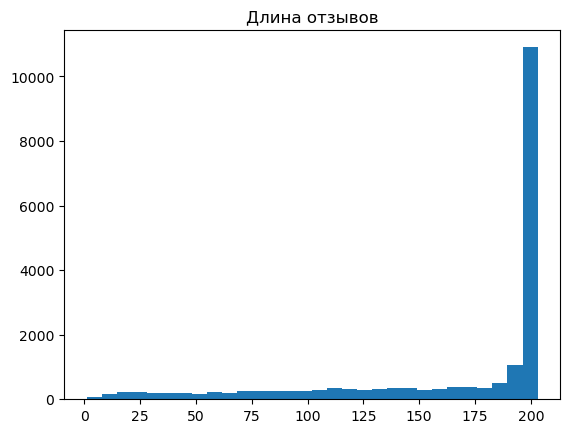

In [8]:
plt.title('Длина отзывов')
plt.hist(list(map(len, df['summary_fin'])), bins=30)
plt.show()

Длина отзывов небольшая - максимальная длина чуть больше 200 слов, скорее всего есть ограничение на сайте. Таким образом, не нужны особо длинные вектора - будем использовать на 200 значений.

Поделим все данные на train/test, выделем только рейтинги и тексты отзывов.

In [9]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(df['summary_fin'], 
                                                            df['rating'], 
                                                            test_size=0.2, 
                                                            random_state=42)

print(f'Train texts {len(train_texts)}, labels {len(train_y)}')
print(f'Test texts {len(test_texts)}, labels {len(test_y)}')

Train texts 15656, labels 15656
Test texts 3914, labels 3914


# Часть 2. Моделирование

Подготовим функцию для токенизации и обработки текстов отзывов. Функция будет выполнять следующие задачи по обработке текаста отзыва:

<li> удалит пунктуацию
<li> оставит только слова из букв русского алфавита. В корпусе текстов есть отзывы на иностранных языках, они обнулятся, но их часть незначительна. Они не слишком существенно исказят рещультаты работы моделей.
<li>    токенизирует отдельные слова
<li>    вернет номальную форму слова
<li>    удалит стоп-слова

In [10]:
import string
import nltk
import re
import warnings
warnings.filterwarnings("ignore")

import pymorphy2 
morph = pymorphy2.MorphAnalyzer()

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop_words.extend(['просто','вообще','она', 'такой', 'который', 'данный', 'этот', 'её', 'этот',
                  'это','эта', 'очень', 'мой', 'твой', 'его', 'наш', 'их','браво', 'здравствуйте', 
                   'спасибо' ,'свой', 'один', 'ещё', 'всё', '«', '»', '...'])

In [12]:
def tokenize(series):

    texts = []
     
    for ind, text in series.items():

        text_lower = text.lower()
        text_lower = re.sub(re.compile('[^\w\s]'), ' ', text_lower)
        text_lower = re.sub(re.compile('[^а-яА-Я ]'), '', text_lower)
        text_lower = text_lower.replace('(','')
        text_lower = text_lower.replace(')','')
        text_lower = text_lower.replace('”','')
        tokens = word_tokenizer.tokenize(text_lower)
        tokens = [morph.parse(word)[0].normal_form for word in tokens]
        tokens = [word for word in tokens if(word not in stop_words)]
        texts.append(tokens)
    
    return texts

In [13]:
train = tokenize(train_texts)
test = tokenize(test_texts)

## Часть 2.1 Векторизация с помощью TfidfVectorizer

Будем использовать TfidfVectorizer для векторизации слов в отзывах, при этом отключим токенизацию и снижение регистра, так как это уже сделали на предыдущем шаге.

В качестве моделей для оценки качества векторизации воспользуемся XGBRFClassifier и LogisticRegression и оценим тональность отзывов. Будем подбирать параметы как для классификатора, так и для векторайзера. 

**Для векторайзера:**
<li> частоту встречаемости слов
<li> величину биграмма
    
**Для бустинга:**
<li>    кол-во деревьев
<li>    максимальную глубину деревьев
<li>    scale_pos_weight - параметр для балансировки классов, иначе предскажет только основной класс
    
**Для лог регрессии:**
<li>   class_weight - параметр для балансировки классов, иначе как с бустингом будет предсказывать только основной класс 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier

#preprocesser = FunctionTransformer(tokenization)

vectorizer = TfidfVectorizer(max_features = 500, norm = None,\
                             tokenizer = lambda x:x,
                             lowercase=False).fit(train)
clf = XGBRFClassifier(learning_rate = 0.05)

pipe = Pipeline([('vectorizer', vectorizer), 
                 ('classifier', clf)])

param_grid = {'vectorizer__max_df':(0.5,0.75, 1),
              'vectorizer__min_df': (0.01, 0.1),
              'vectorizer__ngram_range':[(1,2), (2,2), (1,3)],
              'classifier__max_depth':[6,12],
              'classifier__n_estimators': [200,300,400],
              'classifier__scale_pos_weight': [0.5, 0.2, 0.05]
             }

grid_tf_idf = GridSearchCV(pipe, param_grid=param_grid, cv = 2, scoring = 'f1_macro', verbose=False)
grid_tf_idf.fit(train,train_y)

grid_tf_idf.best_estimator_.get_params()

{'memory': None,
 'steps': [('vectorizer',
   TfidfVectorizer(lowercase=False, max_df=0.5, max_features=500, min_df=0.01,
                   ngram_range=(1, 2), norm=None,
                   tokenizer=<function <lambda> at 0x0000015EB2D1CA60>)),
  ('classifier',
   XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bytree=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05, max_bin=None,
                   max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=12, max_leaves=None,
                   min_child_weight=None, missing=nan, monotone_constraints=None,
                   n_estimators=200, n_jobs=None, num_parallel_tree=None,
              

In [15]:
from sklearn.metrics import classification_report

print(classification_report(test_y, grid_tf_idf.predict(test)))

              precision    recall  f1-score   support

           0       0.51      0.77      0.61       830
           1       0.93      0.80      0.86      3084

    accuracy                           0.79      3914
   macro avg       0.72      0.79      0.74      3914
weighted avg       0.84      0.79      0.81      3914



In [16]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features = 500, norm = None,\
                             tokenizer = lambda x:x,
                             lowercase=False).fit(train)
clf = LogisticRegression(solver = 'liblinear', penalty = 'l1')

pipe = Pipeline([('vectorizer', vectorizer), ('classifier', clf)])

param_grid = {'vectorizer__max_df':(0.5,0.75, 1),
              'vectorizer__min_df': (0.01, 0.1),
              'vectorizer__ngram_range':[(1,2), (2,2), (1,3)],
              'classifier__class_weight':[{1: 0.02, 0: 0.98},
                                          {1: 0.3, 0: 0.7},
                                          {1: 0.5, 0: 0.5}
                                         ]
             }

grid_log_tf_idf = GridSearchCV(pipe, param_grid=param_grid, cv = 2, scoring = 'f1_macro', verbose=False)
grid_log_tf_idf.fit(train,train_y)

grid_log_tf_idf.best_estimator_.get_params()

{'memory': None,
 'steps': [('vectorizer',
   TfidfVectorizer(lowercase=False, max_df=0.5, max_features=500, min_df=0.01,
                   ngram_range=(1, 3), norm=None,
                   tokenizer=<function <lambda> at 0x0000015EBC0E2700>)),
  ('classifier',
   LogisticRegression(class_weight={0: 0.5, 1: 0.5}, penalty='l1',
                      solver='liblinear'))],
 'verbose': False,
 'vectorizer': TfidfVectorizer(lowercase=False, max_df=0.5, max_features=500, min_df=0.01,
                 ngram_range=(1, 3), norm=None,
                 tokenizer=<function <lambda> at 0x0000015EBC0E2700>),
 'classifier': LogisticRegression(class_weight={0: 0.5, 1: 0.5}, penalty='l1',
                    solver='liblinear'),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': False,
 'vectorizer__max_df': 0.5,
 'vectori

In [17]:
print(classification_report(test_y, grid_log_tf_idf.predict(test)))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71       830
           1       0.91      0.96      0.93      3084

    accuracy                           0.89      3914
   macro avg       0.86      0.79      0.82      3914
weighted avg       0.89      0.89      0.88      3914



В приниципе классификаторы сработали неплохо на векторах, созданных с помощью TfIdf: у бустинга получилось f1 для меньшего класса 0,61 и лог регресии 0,71. Регрессия пока дает лучшие результаты. Посмотрим, улучшиться ли качество на более сложных векторах.

## Часть 2.2 Векторизация с помощью Word2Vec и FastText

Для этой части обучим вектора на корпусе имеющихся отзывов с помощью Word2Vec и FastText из библиотеки gensim. Для оценки качества векторов будем использовать такие же модели как и в предыдущем случае.

При этом при расчете вектора полного отзыва подсчитаем среднее взвешенное всех векторов слов в тексте, в качестве веса возьмем метрику частотности слов по методу TfIdf.

In [18]:
import gensim
from gensim.models import Word2Vec

w2v_model = Word2Vec(train, window=5, min_count=1, vector_size=200, negative=5)

Посмотрим, как сработало обучение и найдем близкие по векторам слова для слов кухня, меню и официант.

In [19]:
w2v_model.wv.most_similar('кухня')

[('качественный', 0.9776404500007629),
 ('расположение', 0.9766843318939209),
 ('звук', 0.9747908711433411),
 ('великолепный', 0.9744771718978882),
 ('быстрый', 0.974334180355072),
 ('изысканный', 0.9736382961273193),
 ('ненавязчивый', 0.9720175266265869),
 ('еда', 0.9712106585502625),
 ('достойный', 0.9707204103469849),
 ('потрясать', 0.9696837663650513)]

In [20]:
w2v_model.wv.most_similar('меню')

[('любой', 0.9876878261566162),
 ('напиток', 0.9864033460617065),
 ('широкий', 0.9855672121047974),
 ('вкус', 0.9830755591392517),
 ('разнообразие', 0.9828670024871826),
 ('обширный', 0.9824404716491699),
 ('винный', 0.9807679057121277),
 ('больший', 0.9806721210479736),
 ('ассортимент', 0.9804694652557373),
 ('приготовить', 0.9773731827735901)]

In [21]:
w2v_model.wv.most_similar('официант')

[('расторопный', 0.9748658537864685),
 ('обслуживать', 0.9693419933319092),
 ('шустрый', 0.9677814245223999),
 ('отдельный', 0.9667377471923828),
 ('индивидуальный', 0.9527078866958618),
 ('предупредительный', 0.9506595730781555),
 ('максим', 0.9484384655952454),
 ('уделить', 0.9476397037506104),
 ('респект', 0.9468647241592407),
 ('обходительный', 0.9465464353561401)]

Рассчитаем метрику TfIdf для трейна, при этом только в TfidfVectorizer токенизацию и снижение регистра, так как это уже сделали. Соберем все метрики в словарь, где ключ - это само слово, значение - его метрика.

In [22]:
tfidf = TfidfVectorizer(max_features = 500, 
                        norm = None,
                        tokenizer = lambda x:x,
                        lowercase=False)
tfidf.fit_transform(train)
w_weights = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [23]:
def text_vector(text, model):
    res = np.zeros(200)
    count = 0
    total_weights = 0
    for word in text:
        try:
            res += model.wv[word] *  w_weights[word]
            count += 1
            total_weights += w_weights[word]
        except:
            pass
    if count > 0:
        return res/total_weights
    else:
        return res

In [24]:
from tqdm import tqdm_notebook
texts_w_mean_vect = [text_vector(text, w2v_model) for text in tqdm_notebook(train)]
np_texts_mean_vect = np.vstack(texts_w_mean_vect)
np_texts_mean_vect.shape

  0%|          | 0/15656 [00:00<?, ?it/s]

(15656, 200)

In [25]:
test_w_mean_vect = [text_vector(text, w2v_model) for text in tqdm_notebook(test)]
np_test_mean_vect = np.vstack(test_w_mean_vect)
np_test_mean_vect.shape

  0%|          | 0/3914 [00:00<?, ?it/s]

(3914, 200)

In [26]:
clf = XGBRFClassifier(learning_rate = 0.05)

param_grid = {'max_depth':[6,12],
              'n_estimators': [200,300,400],
              'scale_pos_weight': [0.5, 0.2, 0.1]
             }

grid_w2v = GridSearchCV(clf, param_grid=param_grid, cv = 3, scoring = 'f1_macro', verbose=False)
grid_w2v.fit(np_texts_mean_vect,train_y)

grid_w2v.best_estimator_.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 0.05,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [27]:
print(classification_report(test_y, grid_w2v.predict(np_test_mean_vect)))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       830
           1       0.89      0.93      0.91      3084

    accuracy                           0.86      3914
   macro avg       0.79      0.76      0.77      3914
weighted avg       0.85      0.86      0.85      3914



In [28]:
clf = LogisticRegression(solver = 'liblinear', penalty = 'l1')

param_grid = {'class_weight':[{1: 0.02, 0: 0.98},
                              {1: 0.3, 0: 0.7},
                              {1: 0.5, 0: 0.5}
                                         ]
             }

grid_log_w2v = GridSearchCV(clf, param_grid=param_grid, cv = 3, scoring = 'f1_macro', verbose=False)
grid_log_w2v.fit(np_texts_mean_vect,train_y)

grid_log_w2v.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': {1: 0.3, 0: 0.7},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
print(classification_report(test_y, grid_log_w2v.predict(np_test_mean_vect)))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       830
           1       0.92      0.90      0.91      3084

    accuracy                           0.86      3914
   macro avg       0.79      0.80      0.79      3914
weighted avg       0.86      0.86      0.86      3914



Пока результат особо не поменялся, 0.63 и 0.68 по меньшему классу у f1. Посмотрим, что даст fasttext.

In [30]:
from gensim.models import FastText

ft_model = FastText(train, window=5, min_count=1, vector_size=200, negative=5)

In [31]:
ft_model.wv.most_similar('кухня')

[('кухн', 0.9969530701637268),
 ('вкухня', 0.9920405745506287),
 ('еда', 0.9816648960113525),
 ('цветомузыка', 0.9810616970062256),
 ('клыкач', 0.9810440540313721),
 ('дизайн', 0.9807983040809631),
 ('звук', 0.9806852340698242),
 ('инерьер', 0.9773003458976746),
 ('обстано', 0.9766284227371216),
 ('цейтнот', 0.9728177189826965)]

In [32]:
ft_model.wv.most_similar('меню')

[('блюд', 0.9911110401153564),
 ('твёрдо', 0.989288866519928),
 ('блюдо', 0.987074613571167),
 ('сдача', 0.9857079982757568),
 ('едо', 0.9856400489807129),
 ('изблюдо', 0.9855017066001892),
 ('псевдо', 0.9852367043495178),
 ('блю', 0.982857346534729),
 ('свежак', 0.9807338118553162),
 ('напиток', 0.9784350395202637)]

In [33]:
ft_model.wv.most_similar('официант')

[('официан', 0.999367892742157),
 ('оффициант', 0.9990085959434509),
 ('афициант', 0.9986642003059387),
 ('офици', 0.9985799193382263),
 ('официанк', 0.9981504678726196),
 ('официа', 0.9981024265289307),
 ('офи', 0.997166633605957),
 ('официвнт', 0.9963051080703735),
 ('официанткин', 0.9950326681137085),
 ('официанткисупыкомпот', 0.9901198148727417)]

Немного странные по близости слова выдает алгоритм, мне больше понравиласт работа word2vec для этих же слов.

In [34]:
ft_texts_w_mean_vect = [text_vector(text, ft_model) for text in tqdm_notebook(train)]
ft_np_texts_mean_vect = np.vstack(ft_texts_w_mean_vect)
ft_np_texts_mean_vect.shape

  0%|          | 0/15656 [00:00<?, ?it/s]

(15656, 200)

In [35]:
ft_test_w_mean_vect = [text_vector(text, ft_model) for text in tqdm_notebook(test)]
ft_np_test_mean_vect = np.vstack(ft_test_w_mean_vect)
ft_np_test_mean_vect.shape

  0%|          | 0/3914 [00:00<?, ?it/s]

(3914, 200)

In [36]:
clf = XGBRFClassifier(learning_rate = 0.05)

param_grid = {'max_depth':[6,12],
              'n_estimators': [200,300,400],
              'scale_pos_weight': [0.5, 0.2, 0.1]
             }

grid_ft = GridSearchCV(clf, param_grid=param_grid, cv = 3, scoring = 'f1_macro', verbose=False)
grid_ft.fit(ft_np_texts_mean_vect,train_y)

grid_ft.best_estimator_.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 0.05,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': 0.2,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [37]:
print(classification_report(test_y, grid_ft.predict(ft_np_test_mean_vect)))

              precision    recall  f1-score   support

           0       0.59      0.69      0.64       830
           1       0.91      0.87      0.89      3084

    accuracy                           0.83      3914
   macro avg       0.75      0.78      0.77      3914
weighted avg       0.85      0.83      0.84      3914



In [38]:
clf = LogisticRegression(solver = 'liblinear', penalty = 'l1')

param_grid = {'class_weight':[{1: 0.02, 0: 0.98},
                              {1: 0.3, 0: 0.7},
                              {1: 0.5, 0: 0.5}
                                         ]
             }

grid_log_ft = GridSearchCV(clf, param_grid=param_grid, cv = 3, scoring = 'f1_macro', verbose=False)
grid_log_ft.fit(ft_np_texts_mean_vect,train_y)

grid_log_ft.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': {1: 0.3, 0: 0.7},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [39]:
print(classification_report(test_y, grid_log_ft.predict(ft_np_test_mean_vect)))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       830
           1       0.91      0.88      0.90      3084

    accuracy                           0.84      3914
   macro avg       0.76      0.78      0.77      3914
weighted avg       0.84      0.84      0.84      3914



## Часть 2.3 Векторизация с помощью предобученной модели

Воспользуемся готовой моделью с сайта https://rusvectores.org/ru/models/ для векторизации: выберем **araneum_none_fasttextskipgram_300_5_2018**. В ней довольно большой словарь и длина вектора 300, что даже много для нашей задачи.


In [40]:
model_pretrained = gensim.models.KeyedVectors.load('araneum_none_fasttextskipgram_300_5_2018.model')

Придется немного поменять функцию для векторизации :(

In [41]:
def text_vector_ready(text):
    res = np.zeros(300)
    count = 0
    total_weights = 0
    for word in text:
        try:
            res += model_pretrained[word] *  w_weights[word]
            count += 1
            total_weights += w_weights[word]
        except:
            pass
    if count > 0:
        return res/total_weights
    else:
        return res

In [42]:
ready_texts_w_mean_vect = [text_vector_ready(text) for text in tqdm_notebook(train)]
ready_np_texts_mean_vect = np.vstack(ready_texts_w_mean_vect)
ready_np_texts_mean_vect.shape

  0%|          | 0/15656 [00:00<?, ?it/s]

(15656, 300)

In [43]:
ready_test_w_mean_vect = [text_vector_ready(text) for text in tqdm_notebook(test)]
ready_np_test_mean_vect = np.vstack(ready_test_w_mean_vect)
ready_np_test_mean_vect.shape

  0%|          | 0/3914 [00:00<?, ?it/s]

(3914, 300)

In [44]:
clf = XGBRFClassifier(learning_rate = 0.05)

param_grid = {'max_depth':[6,12],
              'n_estimators': [200,300,400],
              'scale_pos_weight': [0.5, 0.2, 0.1]
             }

pretrained_boost = GridSearchCV(clf, param_grid=param_grid, cv = 3, scoring = 'f1_macro', verbose=False)
pretrained_boost.fit(ready_np_texts_mean_vect,train_y)

pretrained_boost.best_estimator_.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 0.05,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': 0.2,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [45]:
print(classification_report(test_y, pretrained_boost.predict(ready_np_test_mean_vect)))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       830
           1       0.92      0.90      0.91      3084

    accuracy                           0.86      3914
   macro avg       0.79      0.80      0.80      3914
weighted avg       0.86      0.86      0.86      3914



In [46]:
clf = LogisticRegression(solver = 'liblinear', penalty = 'l1')

param_grid = {'class_weight':[{1: 0.02, 0: 0.98},
                              {1: 0.3, 0: 0.7},
                              {1: 0.5, 0: 0.5}
                                         ]
             }

pretrained_log = GridSearchCV(clf, param_grid=param_grid, cv = 3, scoring = 'f1_macro', verbose=False)
pretrained_log.fit(ready_np_texts_mean_vect,train_y)

pretrained_log.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': {1: 0.3, 0: 0.7},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [47]:
print(classification_report(test_y, pretrained_log.predict(ready_np_test_mean_vect)))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       830
           1       0.94      0.91      0.93      3084

    accuracy                           0.88      3914
   macro avg       0.82      0.85      0.83      3914
weighted avg       0.89      0.88      0.89      3914



## Сравнение моделей и выводы

Посторим для каждой модели (их получилось 6). Для каждой построим матрицу ошибок и выведем f1 для меньшего класса.

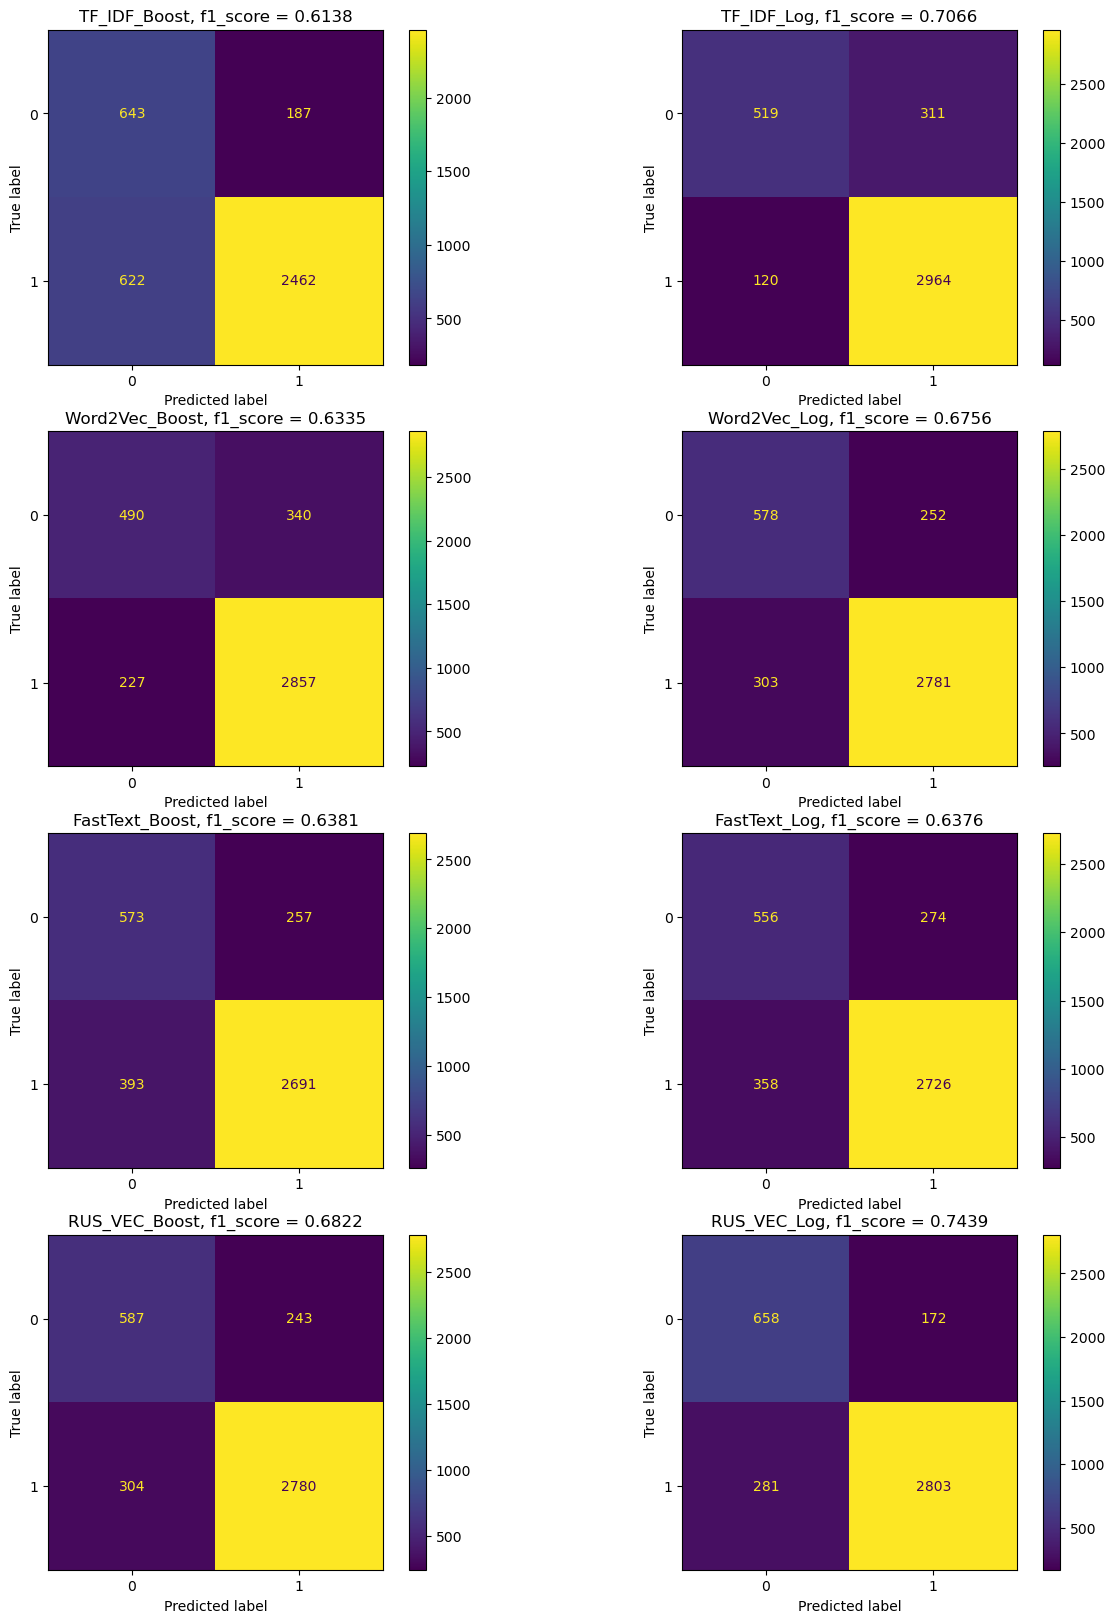

In [48]:
from sklearn import metrics
from sklearn.metrics import  f1_score

labels = ['TF_IDF_Boost', 'TF_IDF_Log', 'Word2Vec_Boost', 'Word2Vec_Log',
         'FastText_Boost', 'FastText_Log', 'RUS_VEC_Boost','RUS_VEC_Log']

predictions = [grid_tf_idf.predict(test),
               grid_log_tf_idf.predict(test), 
               grid_w2v.predict(np_test_mean_vect),
               grid_log_w2v.predict(np_test_mean_vect),
               grid_ft.predict(ft_np_test_mean_vect),
               grid_log_ft.predict(ft_np_test_mean_vect),
               pretrained_boost.predict(ready_np_test_mean_vect),
               pretrained_log.predict(ready_np_test_mean_vect)]

fig, axes = plt.subplots (nrows = 4, ncols = 2, figsize=(15,20))

#plt.tight_layout()
for i, label in enumerate(zip(labels, predictions)):
    metrics.ConfusionMatrixDisplay.from_predictions(test_y, label[1], ax = axes[i//2,i%2])
    axes[i//2,i%2].set_title(f'{label[0]}, f1_score = {round(f1_score(test_y, label[1], pos_label = 0),4)}')
#plt.suptitle('Сравнение результатов работы алгоритмов', fontsize = 12)
plt.show()

Итак, **лучше всего сработали вектора из уже предообученной модели RusVec**. Использование векторов из этой библиотеки дало меньше ошибок для меньшего класса с негативными отзывами. На 2-м месте - вектора, созданные на текущем корпусе текста. Модели делали больше ошибок для меньшего класса. Хуже всех модели сработали на векторах tfidf - были проблемы с отнесением к меньшему классу значений из большего (модель пыталась сравнять классы). 